In [4]:
import numpy as np
import matplotlib.pyplot as plt
import math as m

### Functions


In [97]:
def savefig(filename, ddir = '<your directory>'):
    plt.savefig(ddir+filename+".png", bbox_inches = 'tight') # save plot as png-file 
    
    return print('File successful saved as:', filename)

def Inizialisation(L, dx, u0, cfl, SpectralMethod = 'False'):
    dt = Stability(cfl, u0, dx)    #Timesteps [s]
    
    if SpectralMethod == 'True':
        tmax = int(L/(dt*u0))      #Number timesteps for a full cycle
    else:
        tmax = int(L/(dt*u0)*1e1)      

    
    nx = int(L/dx)             #Number of grid-points

    c0  = 1                    #Concentration at t=0
    x = (np.arange(0,L+dx,dx)) #Basin

    C = np.zeros((tmax, len(x)))

    for i in range((len(x))):
            if 45<= i <=55:
                C[0,i] = c0
  
    
    print('Timstep:', dt, '[s]')
    print('dx :', dx, '[km]')
    print('nx:', nx)
    print('CFL :', cfl)
    print('Simulation total time:', tmax,'[s]')
    
    return dt, tmax, nx, x, C

def Stability(cfl,u0,dx):
    dt = (cfl*dx)/u0
    return dt


def EF_upwind(L, cfl, x, dt, dx, u0):
    
    dt,tmax, nx, x, C = Inizialisation(L,dx,u0,cfl)

    for n in range(tmax-1):
        for j in range(len(x)):
            C[n+1, j] = C[n,j]- u0 * dt/dx * (C[n,j] - C[n, j-1])
    
    fig = DrawPlot(dt, tmax, x, C, cfl)
                                                       
    return fig


def Lax_Wendroff(L, cfl, x, dt, dx, u0):
    
    dt,tmax, nx, x, C = Inizialisation(L,dx,u0,cfl)

    for n in range(tmax-1):
        for j in range(len(x)):
            if j==((len(x)-1)):
                C[n+1,j] = dt*((-u0*((C[n,0]- C[n,j-1])
                                       /(2*dx)))+((u0**2*dt)/2)*((C[n,0]-2*C[n,j]
                                                                        + C[n,j-1])/(dx**2)))+C[n,j]                                                                
            else:
                C[n+1,j] = dt*((-u0*((C[n,j+1]- C[n,j-1])
                                   /(2*dx)))+((u0**2*dt)/2)*((C[n,j+1]-2*C[n,j]
                                                                    + C[n,j-1])/(dx**2)))+C[n,j]
    fig = DrawPlot(dt, tmax, x, C, cfl)
                                                       
    return fig  

def Spectral_method(L, cfl, nx, dt, u0):
    
    dt,tmax, nx, x, C = Inizialisation(L,dx,u0,cfl, SpectralMethod = 'True')

    ##Fourier coefficents
    Ck0 = np.zeros((tmax, int(nx/2)), dtype = complex)

    for k in range(1,int(nx/2)):
        alpha = 0
        beta  = 0
        for j in range(int(nx)):
            alpha = alpha + (2/nx)*(C[0,j]*m.cos((-2*m.pi*k*j)/int(nx)))
            beta  = beta +(2/nx)* (C[0,j]*m.sin((-2*m.pi*k*j)/int(nx)))
        Ck0[0,k] = alpha + 1j*beta
    Ck0[0,0] = 1/nx*np.sum(C[0,:]) + 0j

    ##Matsuno Scheme
    for n in range(tmax-1):
        for k in range(int(nx/2)):
            Ck_predictor = Ck0[n,k] - dt*(2*m.pi*1j*u0*k*Ck0[n,k])/L    #predictor
            Ck0[n+1, k] = Ck0[n,k] - dt*(2*m.pi*1j*u0*k*Ck_predictor)/L #corrector

    ##Inversion to return in physical domain
    for n in range(1,tmax):                   
        for j in range (int(nx)) :
            C[n,j] = 0
            for k in range (int(nx/2)):
                C[n,j] = C[n,j] + np.real(Ck0[n,k]*np.exp((2*m.pi*1j*k*j)/nx))
    
    fig = DrawPlot(dt, tmax, x, C, cfl)
                                                       
    return fig

def DrawPlot(dt, tmax, x, C, cfl, title = 'Timestep (dt):'+ str(int(dt))+'s', save = 'False'):
    
    fig = plt.figure(figsize = (8,4))

    for r in np.arange(0,tmax,int((tmax/5))):
        plt.plot(x, C[int(r),:],label='{} it'.format(int(r*dt/tmax)))

    plt.legend(bbox_to_anchor = (1.2,1.02))
    plt.title(title, fontsize = 20)
    plt.ylabel('Concentration', fontsize = 16, labelpad = 15)
    plt.xlabel('Physical space x',fontsize = 16, labelpad = 15)

    plt.tick_params(labelsize = 12)
    
    outputname = "\." + str(title) + str(dt)+'dt' + str(cfl)

    if save == 'True':
        savefig(outputname) 
    
    return fig

### Parameters

In [84]:
L  = 2500    #Size basin [km]
dx = 25      #Length grid-cells [km]
u0 = 0.01    #Velocity [km/s]
cfl = 0.5    #Stability criterion (<=1)

### Euler forward in time and upwind in space
<br>
$C_j^{n+1} = u_0 \Delta t \frac{C_j^n - C_{j-1}^n}{\Delta x} + C_j^n$,

<br>
<br>
with $n$ the time-index and $j$ the space-index.

Timstep: 1250.0 [s]
dx : 25 [km]
nx: 100
CFL : 0.5
Simulation total time: 2000 [s]


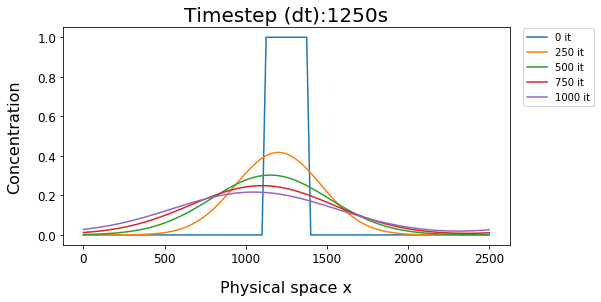

In [98]:
C_EF = EF_upwind(L, cfl, x, dt, dx, u0)

### Lax-Wendroff

<br>
 $C_j^{n+1}  \approx -u_0 \Delta t\left(\frac{C_{j+1}^n + C_{j-1}^n}{2\Delta x}\right) + \frac{u_0^2\Delta t^2}{2}\left( \frac{C_{j+1}^n - 2C_j^n + C_{j-1}^n}{\Delta x^2}\right) + C_j^n$,
 
<br>
<br>

with $n$ the time-index, and $j$ the space-index.

Timstep: 1250.0 [s]
dx : 25 [km]
nx: 100
CFL : 0.5
Simulation total time: 2000 [s]


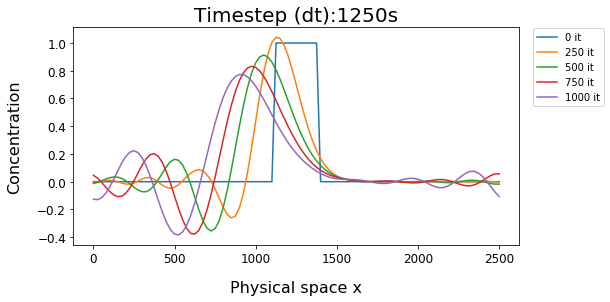

In [99]:
C_LW = Lax_Wendroff(L, cfl, x, dt, dx, u0)


### Spectral method

#### Spectral coefficients:

$\alpha_k = \frac{2}{J}\sum_{j=0}^{J-1}C_j \cos{}\left(\frac{-2\pi kj}{j}\right); \; \beta_k = \frac{2}{J}\sum_{j=0}^{J-1}C_j \sin\left(\frac{-2\pi kj}{j}\right)$

<br>

#### Matsuno time-stepping:

$\text{Predictor step:}\; C^{*^{n+1}}_k = - C_k^n \Delta t\frac{2\pi u_0k}{L}+ C_k^n \\
    \text{Corrector step:}\; C_k^{n+1} = -C^{*^{n+1}}_k\Delta t\frac{2\pi u_0k}{L} + C_k^n$
<br>

#### Inverse Fourrier transform:

$\frac{\partial C_k}{\partial t} = - \frac{2 \pi i u_0 k}{L} C_k$


Timstep: 25.0 [s]
dx : 25 [km]
nx: 100
CFL : 0.01
Simulation total time: 10000 [s]


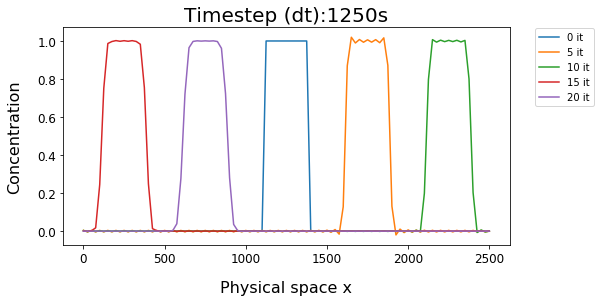

In [102]:
cfl = 0.01 #Nb: stability criterion different for Matsuno (i.e., $dt \leq \frac{1}{ku_0}$)
C_S_final = Spectral_method(L, cfl, nx, dt, u0)
